In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [ ]:
data_url= "http://lib.stat.cmu.edu/datasets/boston"

raw_df=pd.read_csv(
    data_url,
    sep=r"\s+",
    skiprows=22,
    header=None
)

# Construct full feature matrix
X_full=np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])

# Target (MEDV)
y=raw_df.values[1::2, 2].reshape(-1, 1)


In [ ]:
# Select required features first
X = X_full[:, [5, 0]]   # RM, CRIM

# Normalize once
X = (X - X.mean(axis=0)) / X.std(axis=0)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [ ]:
def relu(z):
    return np.maximum(0, z)

def relu_derivative(z):
    return (z > 0).astype(float)


Loss function

In [ ]:
def mse(y, y_hat):
    return np.mean((y - y_hat) ** 2)


Neural Network

In [ ]:
class NeuralNetwork:
    def __init__(self, lr=0.01, optimizer="gd"):
        self.lr = lr
        self.optimizer = optimizer

        # Initialize weights
        self.W1 = np.random.randn(2, 5) * 0.01
        self.b1 = np.zeros((1, 5))

        self.W2 = np.random.randn(5, 3) * 0.01
        self.b2 = np.zeros((1, 3))

        self.W3 = np.random.randn(3, 1) * 0.01
        self.b3 = np.zeros((1, 1))

        # Momentum / Adam params
        self.v = {}
        self.m = {}
        self.t = 1


    def forward(self, X):
        self.z1 = X @ self.W1 + self.b1
        self.a1 = relu(self.z1)

        self.z2 = self.a1 @ self.W2 + self.b2
        self.a2 = relu(self.z2)

        self.y_hat = self.a2 @ self.W3 + self.b3
        return self.y_hat


    def backward(self, X, y):
        n = X.shape[0]

        dL = 2 * (self.y_hat - y) / n

        dW3 = self.a2.T @ dL
        db3 = np.sum(dL, axis=0, keepdims=True)

        da2 = dL @ self.W3.T
        dz2 = da2 * relu_derivative(self.z2)

        dW2 = self.a1.T @ dz2
        db2 = np.sum(dz2, axis=0, keepdims=True)

        da1 = dz2 @ self.W2.T
        dz1 = da1 * relu_derivative(self.z1)

        dW1 = X.T @ dz1
        db1 = np.sum(dz1, axis=0, keepdims=True)

        self.update(dW1, db1, dW2, db2, dW3, db3)

    def update(self, dW1, db1, dW2, db2, dW3, db3):
        if self.optimizer == "gd":
            self.W1 -= self.lr * dW1
            self.b1 -= self.lr * db1
            self.W2 -= self.lr * dW2
            self.b2 -= self.lr * db2
            self.W3 -= self.lr * dW3
            self.b3 -= self.lr * db3

        if self.optimizer == "momentum":
            beta = 0.9
            for param, grad in zip(
                ["W1","b1","W2","b2","W3","b3"],
                [dW1,db1,dW2,db2,dW3,db3]
            ):
                if param not in self.v:
                    self.v[param] = np.zeros_like(grad)
                self.v[param] = beta*self.v[param] + self.lr*grad
                setattr(self, param, getattr(self, param) - self.v[param])

        if self.optimizer == "adam":
            beta1, beta2, eps = 0.9, 0.999, 1e-8
            for param, grad in zip(
                ["W1","b1","W2","b2","W3","b3"],
                [dW1,db1,dW2,db2,dW3,db3]
            ):
                if param not in self.m:
                    self.m[param] = np.zeros_like(grad)
                    self.v[param] = np.zeros_like(grad)

                self.m[param] = beta1*self.m[param] + (1-beta1)*grad
                self.v[param] = beta2*self.v[param] + (1-beta2)*(grad**2)

                m_hat = self.m[param] / (1 - beta1**self.t)
                v_hat = self.v[param] / (1 - beta2**self.t)

                setattr(
                    self, param,
                    getattr(self, param) - self.lr*m_hat/(np.sqrt(v_hat)+eps)
                )
            self.t += 1




In [ ]:
def train(model, X, y, epochs=1000):
    losses = []
    for _ in range(epochs):
        y_hat = model.forward(X)
        losses.append(mse(y, y_hat))
        model.backward(X, y)
    return losses


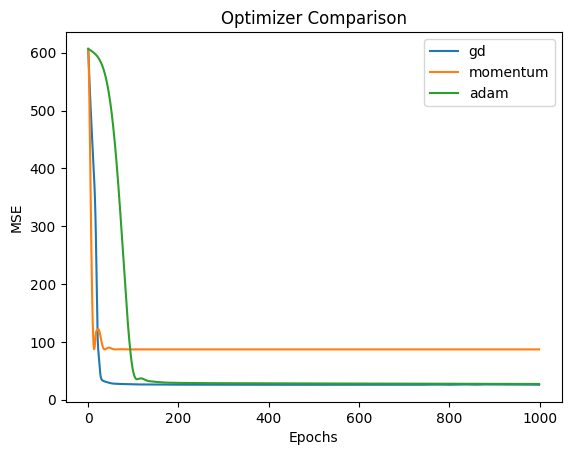

In [ ]:
optimizers = ["gd", "momentum", "adam"]

for opt in optimizers:
    model = NeuralNetwork(lr=0.01, optimizer=opt)
    loss = train(model, X_train, y_train)

    plt.plot(loss, label=opt)

plt.legend()
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.title("Optimizer Comparison")
plt.show()


Test MSE: 24.936307031954566


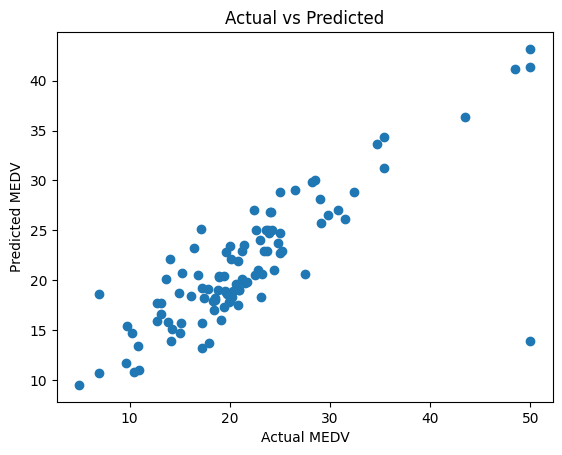

In [ ]:
model = NeuralNetwork(lr=0.01, optimizer="adam")
train(model, X_train, y_train)

y_pred = model.forward(X_test)
print("Test MSE:", mse(y_test, y_pred))

plt.scatter(y_test, y_pred)
plt.xlabel("Actual MEDV")
plt.ylabel("Predicted MEDV")
plt.title("Actual vs Predicted")
plt.show()


Bonus questions

In [ ]:
class NeuralNetwork_3Hidden:
    def __init__(self, input_dim, lr=0.01):
        self.lr = lr

        self.W1 = np.random.randn(input_dim, 5) * 0.01
        self.b1 = np.zeros((1, 5))

        self.W2 = np.random.randn(5, 5) * 0.01
        self.b2 = np.zeros((1, 5))

        self.W3 = np.random.randn(5, 2) * 0.01
        self.b3 = np.zeros((1, 2))

        self.W4 = np.random.randn(2, 1) * 0.01
        self.b4 = np.zeros((1, 1))
    def forward(self, X):
      self.z1 = X @ self.W1 + self.b1
      self.a1 = relu(self.z1)

      self.z2 = self.a1 @ self.W2 + self.b2
      self.a2 = relu(self.z2)

      self.z3 = self.a2 @ self.W3 + self.b3
      self.a3 = relu(self.z3)

      self.y_hat = self.a3 @ self.W4 + self.b4
      return self.y_hat

    def backward(self, X, y):
      m = y.shape[0]

      dy = (2/m) * (self.y_hat - y)

      dW4 = self.a3.T @ dy
      db4 = np.sum(dy, axis=0, keepdims=True)

      da3 = dy @ self.W4.T
      dz3 = da3 * relu_derivative(self.z3)

      dW3 = self.a2.T @ dz3
      db3 = np.sum(dz3, axis=0, keepdims=True)

      da2 = dz3 @ self.W3.T
      dz2 = da2 * relu_derivative(self.z2)

      dW2 = self.a1.T @ dz2
      db2 = np.sum(dz2, axis=0, keepdims=True)

      da1 = dz2 @ self.W2.T
      dz1 = da1 * relu_derivative(self.z1)

      dW1 = X.T @ dz1
      db1 = np.sum(dz1, axis=0, keepdims=True)

      self.W4 -= self.lr * dW4
      self.b4 -= self.lr * db4
      self.W3 -= self.lr * dW3
      self.b3 -= self.lr * db3
      self.W2 -= self.lr * dW2
      self.b2 -= self.lr * db2
      self.W1 -= self.lr * dW1
      self.b1 -= self.lr * db1



In [ ]:
model_3 = NeuralNetwork_3Hidden(input_dim=X_train.shape[1], lr=0.01)
train(model_3, X_train, y_train, epochs=1000)

y_pred_3 = model_3.forward(X_test)
print("Test MSE (3 hidden layers):", mse(y_test, y_pred_3))


In [ ]:
def mse_l2(y, y_hat, model, lambda_=0.001):
    mse_loss = np.mean((y - y_hat) ** 2)
    l2 = (
        np.sum(model.W1**2) +
        np.sum(model.W2**2) +
        np.sum(model.W3**2)
    )
    return mse_loss + lambda_ * l2


In [ ]:
class NeuralNetwork_L2:
    def __init__(self, input_dim, lr=0.01, lambda_=0.001):
        self.lr = lr
        self.lambda_ = lambda_

        self.W1 = np.random.randn(input_dim, 5) * 0.01
        self.b1 = np.zeros((1, 5))

        self.W2 = np.random.randn(5, 5) * 0.01
        self.b2 = np.zeros((1, 5))

        self.W3 = np.random.randn(5, 1) * 0.01
        self.b3 = np.zeros((1, 1))
    def forward(self, X):
        self.z1 = X @ self.W1 + self.b1
        self.a1 = relu(self.z1)

        self.z2 = self.a1 @ self.W2 + self.b2
        self.a2 = relu(self.z2)

        self.y_hat = self.a2 @ self.W3 + self.b3
        return self.y_hat
    def backward(self, X, y):
        m = y.shape[0]

        dy = (2/m) * (self.y_hat - y)

        dW3 = self.a2.T @ dy + self.lambda_ * self.W3
        db3 = np.sum(dy, axis=0, keepdims=True)

        da2 = dy @ self.W3.T
        dz2 = da2 * relu_derivative(self.z2)

        dW2 = self.a1.T @ dz2 + self.lambda_ * self.W2
        db2 = np.sum(dz2, axis=0, keepdims=True)

        da1 = dz2 @ self.W2.T
        dz1 = da1 * relu_derivative(self.z1)

        dW1 = X.T @ dz1 + self.lambda_ * self.W1
        db1 = np.sum(dz1, axis=0, keepdims=True)

        self.W3 -= self.lr * dW3
        self.b3 -= self.lr * db3
        self.W2 -= self.lr * dW2
        self.b2 -= self.lr * db2
        self.W1 -= self.lr * dW1
        self.b1 -= self.lr * db1


In [ ]:
model_l2 = NeuralNetwork_L2(
    input_dim=X_train.shape[1],
    lr=0.01,
    lambda_=0.001
)

losses_l2 = []
epochs = 1000

for _ in range(epochs):
    y_hat = model_l2.forward(X_train)
    losses_l2.append(mse_l2(y_train, y_hat, model_l2))
    model_l2.backward(X_train, y_train)


In [ ]:
y_pred_l2 = model_l2.forward(X_test)
print("Test MSE with L2 Regularization:", mse(y_test, y_pred_l2))


In [ ]:
plt.scatter(y_test, y_pred_l2)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    'r--'
)
plt.xlabel("Actual MEDV")
plt.ylabel("Predicted MEDV")
plt.title("L2 Regularized Model: Actual vs Predicted")
plt.show()
